Esse projeto tem como objetivo criar uma rede neural para conseguir inferir dados sobre um modelo especifo.
<br>O dataset é um conjunto de imagens de flores, totalizando 102 tipos diferentes.
<br>Dataset: [baixar o dataset](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip)
<br>Nesse projeto será realizado as seguintes ações:
* Carregar o dataset
* Obter os tipos diferentes de flores no dataset 
* Imprimir algumas imagens deste dataset
* Carregar uma rede reural pre treinada [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) e configurar o ouput conforme o dataset 
* Validar o % de acuracia do modelo pre treinado
* Treinar o modelo e salvar o melhor resultado
* Carregar o modelo e validar o % de acuracia
* Exibir a probabilidade do modelo acertar a imagem em um subconjunto de imagens.

In [1]:
# Imports here
import os
import numpy as np
import torch

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

%matplotlib inline

## 1) Carregar o dataset

In [2]:
#Para carregar é necessário que já o dataset encontre-se no mesmo diretorio que esse arquivo.
data_dir = 'flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

data_transforms = transforms.Compose([transforms.RandomResizedCrop(224),transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

#É necessário carregar os dados de teste e de treino, e realizar uma transformação dos dados para deixar todos no mesmo padrão.
train_data = datasets.ImageFolder(train_dir, transform=data_transforms)
test_data = datasets.ImageFolder(valid_dir, transform=data_transforms)

# Batch_size é o numero de elementos que será carregado a cada iteração,
#isso serve para não carregar todos os dados de uma unica vez e deixar o treinamento do modelo muito lerdo.
batch_size = 20
num_workers=0

# Prepara os DataLoader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)


## 2)Obter os tipos diferentes de flores no dataset

In [3]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

classes = list(cat_to_name.values())

## 3) Imprimir algumas imagens deste dataset

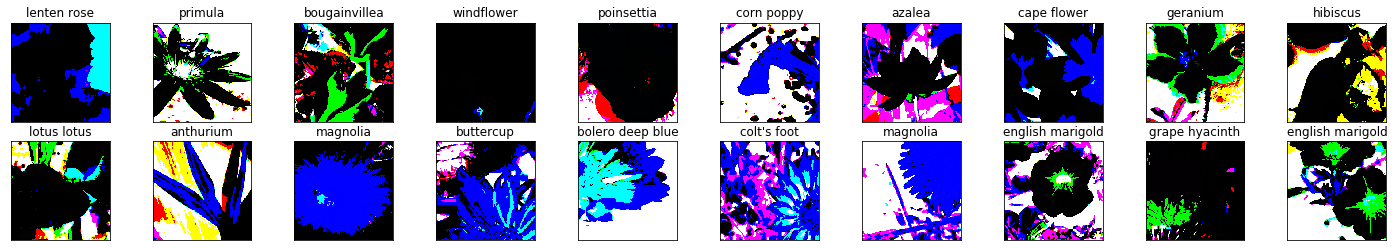

In [4]:

# Obtem um batch de imagens, que foi definido como 20 no primeiro passo.
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # Converte imagens para exibir com numpy

# Imprimi as imagens no batch de imagens com a label correspondente.
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)).astype(np.uint8))
    ax.set_title(classes[labels[idx]])

## 4)Carregar uma rede reural pre treinada [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) e configurar o ouput conforme o dataset 


In [5]:
#Nesse caso foi utilizado a rede resnet18 por não ser muito pesada e por conseguir fornecer um bom resultado nesse caso.
redeNeural = models.resnet18(pretrained=True)

### Configuração extra para habilitar GPU caso o PC possua.

In [6]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [7]:
##Alterar a quantidade de ouput conforme o dataset escolhido, nesse caso 102
from collections import OrderedDict
import torch.nn as nn
n_inputs = redeNeural.fc.in_features   
last_layer = nn.Linear(n_inputs, len(classes))
redeNeural.fc = last_layer

## 5) Validar o % de acuracia do modelo pre treinado

In [8]:
#Antes de validar o modelo é preciso incluir o tipo de criterion e optimizer

import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(redeNeural.fc.parameters(), lr=0.001)

In [27]:
if train_on_gpu:
    redeNeural.cuda()
test_loss = 0.0
size = len(classes);
class_correct = list(0. for i in range(size))
class_total = list(0. for i in range(size))

redeNeural.eval() # prep model for evaluation
test_losses = []

for batch_i, (data, target) in enumerate(test_loader):
    # forward pass: compute predicted outputs by passing inputs to the model
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    output = redeNeural(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        try:
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
        except:
            print("Não foi encontrado o dataset de teste para a classe: ", classes[i])

redeNeural.train()
# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
test_losses.append(test_loss/len(test_loader))
print('Test Loss: {:.6f}\n'.format(test_loss))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


Não foi encontrado o dataset de teste para a classe:  ball moss
Não foi encontrado o dataset de teste para a classe:  love in the mist
Test Loss: 4.685422


Test Accuracy (Overall):  1% (16/818)


## 6) Treinar o modelo e salvar o melhor resultado
Essa talvez seja a etapa mais importante do fluxo de treinamento do modelo.

In [10]:
# Epoch é algo semelhante a iteração no caso de ML(Machine Learning). 
# Quanto mais Epoch mais o modelo será treinado e terá um desempenho melhor. Mas é necessário tomar cuidado com Overfitting.
n_epochs = 30
globalLoss = 100;
for epoch in range(1, n_epochs+1):

    # A perda de treino será incrementada a cada batch 
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for batch_i, (data, target) in enumerate(train_loader):

        ##Utilizar GPU caso esteja disponivel.
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
            
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = redeNeural(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss 
        train_loss += loss.item()
        if batch_i % 20 == 19:    # print training loss every specified number of mini-batches
            train_loss_mean = train_loss / 20;
            print('Epoch %d, Batch %d loss: %.16f' % (epoch, batch_i + 1, train_loss_mean))
            if  train_loss_mean <= globalLoss:
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                globalLoss,
                train_loss_mean))
                torch.save(redeNeural.state_dict(), 'model-saved.pth')
                globalLoss = train_loss_mean
            train_loss = 0.0

Epoch 1, Batch 20 loss: 4.7447462797164919
Validation loss decreased (100.000000 --> 4.744746).  Saving model ...
Epoch 1, Batch 40 loss: 4.7304847002029415
Validation loss decreased (4.744746 --> 4.730485).  Saving model ...
Epoch 1, Batch 60 loss: 4.7470831632614132
Epoch 1, Batch 80 loss: 4.6770964384078981
Validation loss decreased (4.730485 --> 4.677096).  Saving model ...


KeyboardInterrupt: 

## 7) Carregar o modelo e validar o % de acuracia

In [11]:
## Método para reccaregar o modelo já treinado
def _reload_module():
    redeNeural.load_state_dict(torch.load('model-saved.pth'))

In [28]:
# Reccarega o modelo treinado.
_reload_module()
test_loss = 0.0
size = len(classes);

class_correct = list(0. for i in range(size))
class_total = list(0. for i in range(size))

redeNeural.eval() # prep model for evaluation
test_losses = []

for batch_i, (data, target) in enumerate(test_loader):
    # forward pass: compute predicted outputs by passing inputs to the model
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    output = redeNeural(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        try:
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
        except:
            print(target.size())
            print("Não foi encontrado o dataset de teste para a classe: ", classes[i])

redeNeural.train()
# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
test_losses.append(test_loss/len(test_loader))
print('Test Loss: {:.6f}\n'.format(test_loss))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

torch.Size([18])
Não foi encontrado o dataset de teste para a classe:  ball moss
torch.Size([18])
Não foi encontrado o dataset de teste para a classe:  love in the mist
Test Loss: 4.222198


Test Accuracy (Overall): 11% (94/818)


## 8) Exibir a probabilidade do modelo acertar a imagem em um subconjunto de imagens.

Acertos:  0


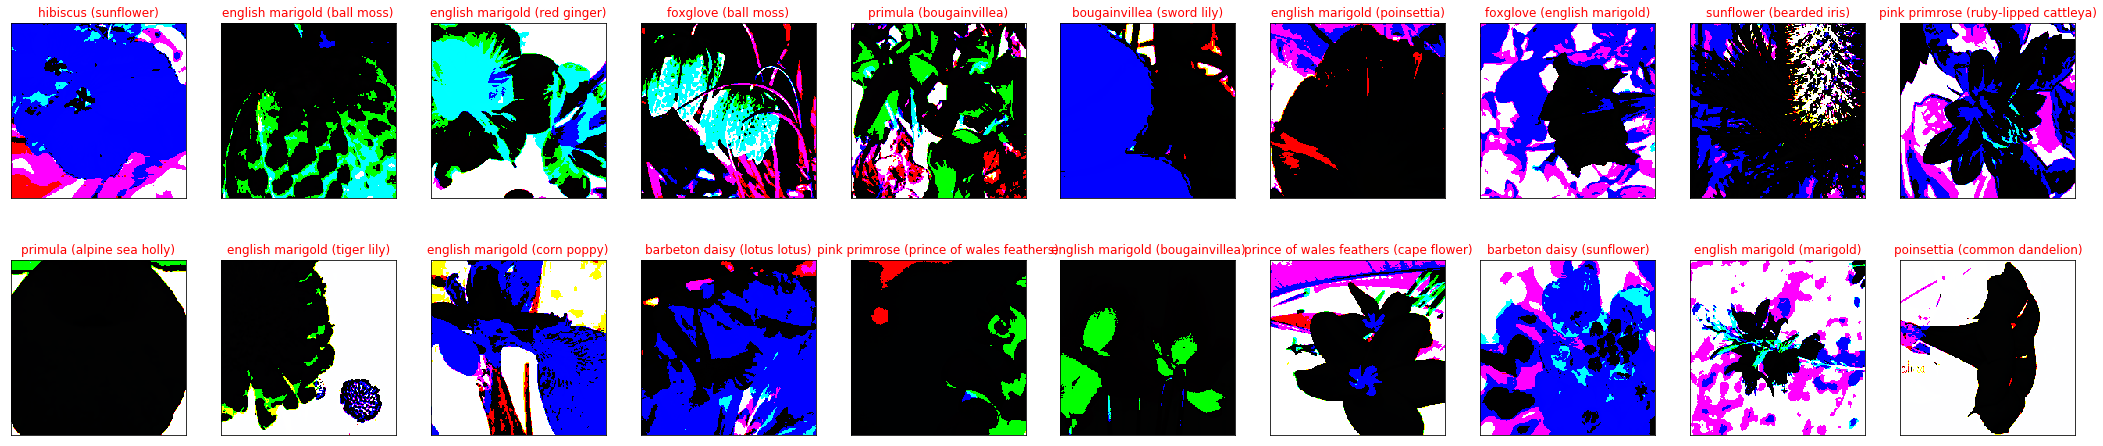

In [26]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()


# move model inputs to cuda, if GPU available
if train_on_gpu:
    imagesCuda = images.cuda()
    redeNeural.cuda()
output = redeNeural(imagesCuda)

# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

images = images.numpy()

# plot the images in the batch, along with predicted and true labels
count = 0
fig = plt.figure(figsize=(37, 8))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)).astype(np.uint8))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))
    if preds[idx].item()==labels[idx].item():
        count +=1
print("Acertos: ", count)